In [30]:
import os
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import platform
from wordcloud import WordCloud
import pandas as pd

In [2]:
# 停用词列表
stopwords = []

# 加载停用词列表
with open('../stopwords/cn_stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

with open('../stopwords/hit_stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

with open('../stopwords/baidu_stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

with open('../stopwords/scu_stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

##### 对中文分词和虚词过滤的简单测试

In [3]:
def preprocess(text):
    # 分词
    words = jieba.lcut(text)
    # 去除虚词
    words = [word for word in words if word not in stopwords]
    f_word = " ".join(words)
    # 返回处理后的词语列表
    return f_word, words

In [4]:
text = '这书是我昨天在杭电图书馆借的。'
f_word, words = preprocess(text)
print(words)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.719 seconds.
Prefix dict has been built successfully.


['这书', '昨天', '杭电', '图书馆']


In [5]:
f_word

'这书 昨天 杭电 图书馆'

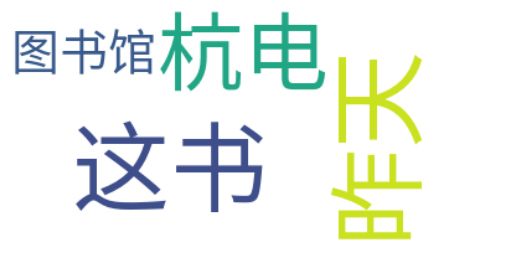

In [6]:
# 根据操作系统类型设置中文字体路径
if platform.system() == 'Windows':
    font_path = r"C:\Windows\Fonts\simsun.ttc"
elif platform.system() == 'Darwin':
    font_path = "/Library/Fonts/Songti.ttc"
else:
    font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"

# 生成词云图，并指定中文字体
wordcloud = WordCloud(font_path=font_path, background_color="white").generate(f_word)

# 显示词云图
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

中文分词和虚词过滤的顺序是有一定影响的。通常情况下，应该先进行中文分词，再进行虚词过滤。原因如下：
首先，如果我们先进行虚词过滤，将虚词删除后再进行中文分词，可能会导致一些实质意义的词语被拆分开来，进而影响分析的准确性。

In [7]:
# 读取train数据集
data = []
labels = []
f_word_list = []
for root, dirs, files in os.walk('./Chinese_Text_Classification_Task_Dataset/train'):
    print('dealing with {}'.format(root.split('/')[-1]))
    for file in files:
        with open(os.path.join(root, file), 'r', encoding='GB2312',errors='ignore') as f:
            content = f.read()
            f_word, words = preprocess(content)
            data.append(' '.join(words))
            labels.append(root.split('/')[-1])
            f_word_list.append(f_word)

dealing with train
dealing with C3-Art
dealing with C31-Enviornment
dealing with C39-Sports
dealing with C34-Economy
dealing with C38-Politics
dealing with C19-Computer


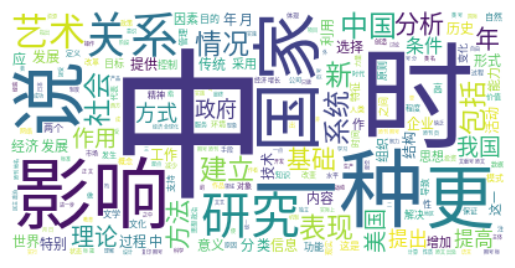

In [8]:
f_words = " ".join(f_word_list)

# 根据操作系统类型设置中文字体路径
if platform.system() == 'Windows':
    font_path = r"C:\Windows\Fonts\simsun.ttc"
elif platform.system() == 'Darwin':
    font_path = "/Library/Fonts/Songti.ttc"
else:
    font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"

# 生成词云图，并指定中文字体
wordcloud = WordCloud(font_path=font_path, background_color="white").generate(f_words)

# 显示词云图
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
# 检测是否data已包含全部的训练数据
len(data)

1200

In [10]:
# 使用TF-IDF算法将文本转换成向量
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)
y = labels

In [11]:
selector = SelectKBest(chi2, k=1000)  # 选择1000个特征
selector.fit(X, y)
X = selector.transform(X)

In [12]:
# 计算特征权重
feature_words = []
weights = []
features = vectorizer.get_feature_names_out() 
feature_weights = selector.scores_
sorted_idx = feature_weights.argsort()[::-1][:1000]
for idx in sorted_idx:
    feature_words.append(features[idx])
    weights.append(feature_weights[idx])
    # print(features[idx], feature_weights[idx])

In [13]:
# 将特征词汇和权重值输入电子表格
df = pd.DataFrame({"Feature Words": feature_words, "Weights": weights})
df.head(37)

,Feature Words,Weights
0,政治,231.753898
1,体育,171.011286
2,艺术,151.928276
3,经济,110.958617
4,民主,67.613340
5,运动员,59.365736
6,文艺,57.517213
7,土壤,55.195053
8,干部,46.643702
9,社会主义,45.823928


In [14]:
# 支持向量机
svm_clf = SVC(kernel='linear')
svm_clf.fit(X, y)

SVC(kernel='linear')

In [15]:
# K近邻
knn_clf = KNeighborsClassifier()
knn_clf.fit(X, y)

KNeighborsClassifier()

In [16]:
# 随机森林
rf_clf = RandomForestClassifier()
rf_clf.fit(X, y)

RandomForestClassifier()

In [20]:
# 决策树
DT_clf = DecisionTreeClassifier()
DT_clf.fit(X, y)

DecisionTreeClassifier()

In [31]:
# 朴素贝叶斯
GNB_clf = MultinomialNB()
GNB_clf.fit(X, y)

MultinomialNB()

In [ ]:
# clf = [svm_clf,knn_clf,rf_clf]

##### 模型测试

In [22]:
# 对新的文本进行分类
test_text = '创作艺术需要社会的包容'
fword, words = preprocess(test_text)
print(words)
X_new = vectorizer.transform([' '.join(words)])
X_new = selector.transform(X_new)
y_new = rf_clf.predict(X_new)
print('Predicted Label:', y_new[0])

['创作', '艺术', '社会', '包容']
Predicted Label: C3-Art


In [23]:
# 读取train数据集
test_data = []
test_labels = []
text_file = []
for root, dirs, files in os.walk('./Chinese_Text_Classification_Task_Dataset/test'):
    print('dealing with {}'.format(root.split('/')[-1]))
    for file in files:
        text_file.append(file)
        with open(os.path.join(root, file), 'r', encoding='GB2312',errors='ignore') as f:
            content = f.read()
            # 中文分词
            words = jieba.lcut(content)
            # 过滤停用词和数字
            words = [word for word in words if word not in stopwords and not word.isdigit()]

            test_data.append(' '.join(words))
            test_labels.append(root.split('/')[-1])

dealing with test
dealing with C3-Art
dealing with C31-Enviornment
dealing with C39-Sports
dealing with C34-Economy
dealing with C38-Politics
dealing with C19-Computer


In [24]:
def diff_clf_pred(clf_model=svm_clf):
    y_pred = []
    for i in range(len(test_data)):
        X_new = vectorizer.transform([test_data[i]])
        X_new = selector.transform(X_new)
        y_new = clf_model.predict(X_new)
        y_pred.append(y_new[0])
    return y_pred

In [25]:
svm_pred = diff_clf_pred(clf_model=svm_clf)

In [26]:
knn_pred = diff_clf_pred(clf_model=knn_clf)

In [27]:
rf_pred = diff_clf_pred(clf_model=rf_clf)

In [28]:
DT_pred = diff_clf_pred(clf_model=DT_clf)

In [32]:
GNB_pred = diff_clf_pred(clf_model=GNB_clf)

In [33]:
print("SVM classification report:\n", classification_report(test_labels, svm_pred))

SVM classification report:
                  precision    recall  f1-score   support

   C19-Computer       0.95      0.99      0.97       100
         C3-Art       0.99      0.97      0.98       100
C31-Enviornment       0.86      1.00      0.93       100
    C34-Economy       0.98      0.92      0.95       100
   C38-Politics       0.98      0.93      0.95       100
     C39-Sports       1.00      0.93      0.96       100

       accuracy                           0.96       600
      macro avg       0.96      0.96      0.96       600
   weighted avg       0.96      0.96      0.96       600



In [34]:
print("KNN classification report:\n", classification_report(test_labels, knn_pred))

KNN classification report:
                  precision    recall  f1-score   support

   C19-Computer       0.94      0.60      0.73       100
         C3-Art       0.53      0.99      0.69       100
C31-Enviornment       0.97      0.84      0.90       100
    C34-Economy       0.95      0.72      0.82       100
   C38-Politics       0.86      0.89      0.87       100
     C39-Sports       1.00      0.81      0.90       100

       accuracy                           0.81       600
      macro avg       0.87      0.81      0.82       600
   weighted avg       0.87      0.81      0.82       600



In [35]:
print("Random Forest classification report:\n", classification_report(test_labels, rf_pred))

Random Forest classification report:
                  precision    recall  f1-score   support

   C19-Computer       0.98      1.00      0.99       100
         C3-Art       0.95      1.00      0.98       100
C31-Enviornment       0.99      0.99      0.99       100
    C34-Economy       0.97      0.91      0.94       100
   C38-Politics       0.91      0.96      0.93       100
     C39-Sports       1.00      0.93      0.96       100

       accuracy                           0.96       600
      macro avg       0.97      0.96      0.96       600
   weighted avg       0.97      0.96      0.96       600



In [36]:
print("Decision Tree classification report:\n", classification_report(test_labels, DT_pred))

Decision Tree classification report:
                  precision    recall  f1-score   support

   C19-Computer       0.98      0.99      0.99       100
         C3-Art       0.94      0.99      0.97       100
C31-Enviornment       0.99      0.97      0.98       100
    C34-Economy       0.95      0.92      0.93       100
   C38-Politics       0.90      0.88      0.89       100
     C39-Sports       0.95      0.96      0.96       100

       accuracy                           0.95       600
      macro avg       0.95      0.95      0.95       600
   weighted avg       0.95      0.95      0.95       600



In [37]:
print("Gaussian Naive Bayes classification report:\n", classification_report(test_labels, GNB_pred))

Gaussian Naive Bayes classification report:
                  precision    recall  f1-score   support

   C19-Computer       0.96      0.98      0.97       100
         C3-Art       0.99      0.99      0.99       100
C31-Enviornment       0.98      0.98      0.98       100
    C34-Economy       0.93      0.85      0.89       100
   C38-Politics       0.85      0.99      0.92       100
     C39-Sports       0.99      0.90      0.94       100

       accuracy                           0.95       600
      macro avg       0.95      0.95      0.95       600
   weighted avg       0.95      0.95      0.95       600



In [38]:
def print_confusion_matrix(clf_pred=svm_pred):
    cm = confusion_matrix(test_labels, clf_pred)
    print("Confusion matrix:")
    print(cm)
    return cm

In [44]:
print('svm_pred',end=" ")
svm_cm = print_confusion_matrix(svm_pred)
print('knn_pred',end=" ")
knn_cm = print_confusion_matrix(knn_pred)
print('rf_pred',end=" ")
rf_cm = print_confusion_matrix(rf_pred)
print('DT_pred',end=" ")
DT_cm = print_confusion_matrix(DT_pred)
print('GNB_pred',end=" ")
GNB_cm = print_confusion_matrix(GNB_pred)

svm_pred Confusion matrix:
[[ 99   0   1   0   0   0]
 [  0  97   3   0   0   0]
 [  0   0 100   0   0   0]
 [  1   0   5  92   2   0]
 [  0   1   4   2  93   0]
 [  4   0   3   0   0  93]]
knn_pred Confusion matrix:
[[60 39  0  1  0  0]
 [ 0 99  0  0  1  0]
 [ 1 14 84  0  1  0]
 [ 1 14  2 72 11  0]
 [ 0  9  0  2 89  0]
 [ 2 13  1  1  2 81]]
rf_pred Confusion matrix:
[[100   0   0   0   0   0]
 [  0 100   0   0   0   0]
 [  1   0  99   0   0   0]
 [  0   0   0  91   9   0]
 [  0   2   0   2  96   0]
 [  1   3   1   1   1  93]]
DT_pred Confusion matrix:
[[99  0  1  0  0  0]
 [ 0 99  0  0  1  0]
 [ 1  0 97  0  0  2]
 [ 0  1  0 92  6  1]
 [ 0  5  0  5 88  2]
 [ 1  0  0  0  3 96]]
GNB_pred Confusion matrix:
[[98  0  0  1  0  1]
 [ 0 99  0  1  0  0]
 [ 0  0 98  2  0  0]
 [ 0  0  0 85 15  0]
 [ 0  0  0  1 99  0]
 [ 4  1  2  1  2 90]]


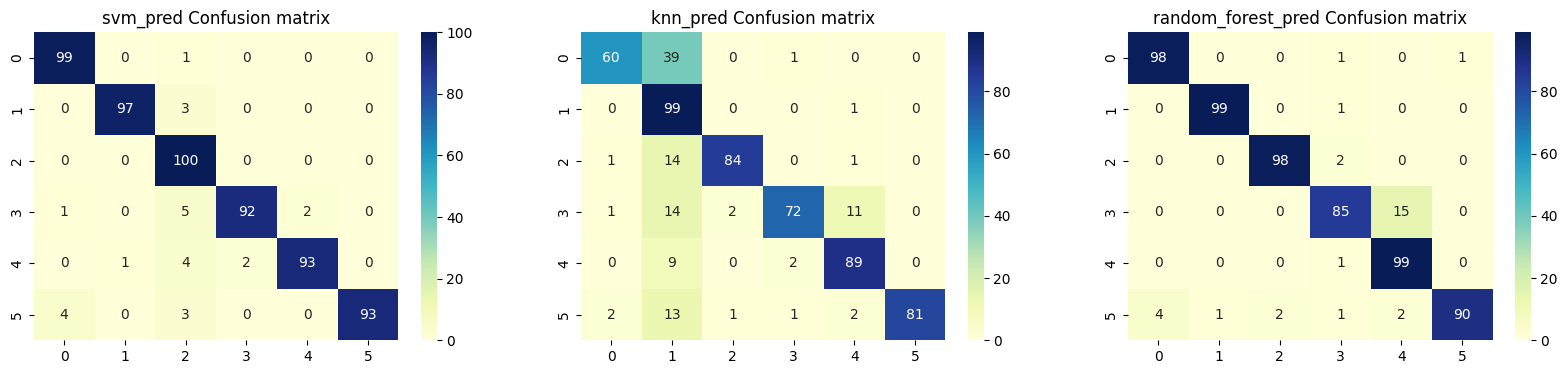

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4)) 
sns.heatmap(svm_cm, annot=True, fmt='d', cmap="YlGnBu", ax=axs[0]) 
sns.heatmap(knn_cm, annot=True, fmt='d', cmap="YlGnBu", ax=axs[1]) 
sns.heatmap(rf_cm, annot=True, fmt='d', cmap="YlGnBu", ax=axs[2])
axs[0].set_title('svm_pred Confusion matrix') 
axs[1].set_title('knn_pred Confusion matrix') 
axs[2].set_title('random_forest_pred Confusion matrix') 
plt.show()

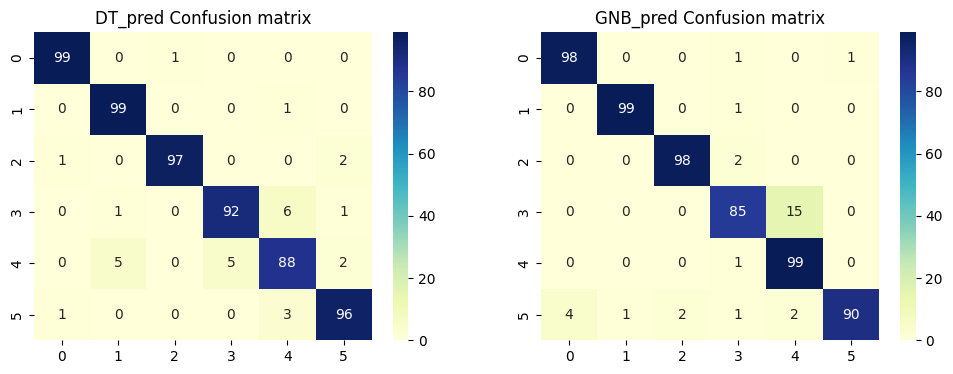

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4)) 
sns.heatmap(DT_cm, annot=True, fmt='d', cmap="YlGnBu", ax=axs[0]) 
sns.heatmap(GNB_cm, annot=True, fmt='d', cmap="YlGnBu", ax=axs[1]) 
axs[0].set_title('DT_pred Confusion matrix') 
axs[1].set_title('GNB_pred Confusion matrix') 
plt.show()

In [50]:
svm_acc = accuracy_score(test_labels, svm_pred)
knn_acc = accuracy_score(test_labels, knn_pred)
rf_acc = accuracy_score(test_labels, rf_pred)
DT_acc = accuracy_score(test_labels, DT_pred)
GNB_acc = accuracy_score(test_labels, GNB_pred)

print("svm 准确率：{:.2f}%".format(svm_acc * 100))
print("knn 准确率：{:.2f}%".format(knn_acc * 100))
print("random forest 准确率：{:.2f}%".format(rf_acc * 100))
print("Decision Tree 准确率：{:.2f}%".format(DT_acc * 100))
print("Guassian Naive Bayes 准确率：{:.2f}%".format(GNB_acc * 100))

svm 准确率：95.67%
knn 准确率：80.83%
random forest 准确率：96.50%
Decision Tree 准确率：95.17%
Guassian Naive Bayes 准确率：94.83%


In [42]:
# 显示一个错误分类的案例
for i in range(len(svm_pred)):
    if rf_pred[i]!=test_labels[i]:
        print("rf_pred is {}, while real label is {}".format(rf_pred[i],test_labels[i]))
        print(text_file[i])
        break

rf_pred is C19-Computer, while real label is C31-Enviornment
C31-Enviornment0052.txt


In [43]:
with open('./Chinese_Text_Classification_Task_Dataset/test/C39-Sports/C39-Sports0198.txt', 'r', encoding='GB2312', errors='ignore') as f:
    content = f.read()

print(content)

【 文献号 】2-3871
【原文出处】新闻与传播研究
【原刊地名】京
【原刊期号】199601
【原刊页号】11-17
【分 类 号】G6
【分 类 名】新闻学
【 作  者 】张西明
【复印期号】199603
【 标  题 】中国电视业的现状和问题
【 正  文 】
    截至1995年年中，中国的电视机拥有量达2.5亿台， 电视观众突破8亿，无线电视台为970余座，有线电视台则多达1200 多家， 另外还有
1000家左右的教育台。电视行业的人通常用“三个一千”的形象说法来描绘这种格局，即“无线一千，有线一千，教育台一千”。〔1 〕从这
组数字看，中国是无可争议的“世界上最大的视听市场”，而且是最繁忙的市场。可以这样说，每天我们的视野中都有各式各样新的建筑拔地
而起，与此同时，我们身边看不见的空间里也每时每刻都在涌现着新的视听信号，渐渐地把电视机的频道全部占满。另一方面，犹如一处处欣
欣向荣的建筑工地背后隐藏着这样那样的无序和混乱一样，透过电视的卫星信号、微波信号和有线电缆展现出的勃勃生机，也能明显感觉到夹
杂其中的纷乱、混乱和浮躁。浮躁中透着勃勃生机，可以说是今天中国电视业的写照，而且也是其可以预见的明天。
    本文意在总结当前我国电视业的主要发展趋势和特点，特别是电视行业内部对现状和发展的看法，笔者希望通过这篇文章与有关专家学者
讨论这个领域的管理和发展问题。
            一、有线电视的发展及遇到的问题
    我国新兴的电视业市场中，发展情况并不是铁板一块。一些新的部门、部类正在崛起，一些传统部门则不得不挖潜、革新。这里只能择要
对一些方面进行描述，破题之处是近年来电视业中发展较快、问题也较多的方面军――有线电视。
    我国的有线电视，自80年代中期开始出现，最近几年迅猛发展。有线电视的优点，是能使观众同时收看到十几个乃至几十个频道，这在较
大程度上丰富了电视屏幕和观众的文化生活。截至1995年5月份， 我国有线电视用户终端数为3000万，经广播电影电视部批准的有线台目前已
达1200座。〔2 〕实际的用户终端数和有线电视台数量远远超过了前两个数。由于经济利益的驱动，全国各地发展有线电视的积极性都非常高
。如在经济实力并不很强的湖南，一般的县、市都安装了有线电视，现在正向乡镇延伸。有的地方，十几个乡都安装了有线电视。按广播电影
电视

#### 通过查看错误案例的原文，发现似乎并不是体育板块的，可能是部分数据标注出现问题